# GRU for Human Activity Recognition

Human activity recognition using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Gatet Recurent Unit cells (GRUs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. Other research on the activity recognition dataset used mostly use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much did the data was preprocessed. 


## Details about input data

I will be using an GRU on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. 

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" />

An GRU is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. 


## Results 

Scroll on! Nice visuals awaits. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from time import time
import os
import sys

In [2]:
# some reflection

def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter
    
if not is_notebook():
    def get_ipython():
        class Mock:
            def run_cell_magic(*args):
                pass
            def system(self, arg):
                os.system(arg)
                
        return Mock()

In [3]:
def find_nb_name():
    from http.server import BaseHTTPRequestHandler, HTTPServer # python3
    class HandleRequests(BaseHTTPRequestHandler):
        def do_GET(self):
            global nb_name
            nb_name = self.requestline.split()[1][1:]
            print("name is found: " + nb_name)

    import socket
    from contextlib import closing

    def find_free_port():
        with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
            s.bind(('',0))
            return s.getsockname()[1]

    host = ''
    port = find_free_port()
    server = HTTPServer((host, port), HandleRequests)
    server.server_activate()#.serve_forever()
    get_ipython().run_cell_magic('javascript', '', 'var i = document.createElement("img");' + 
                                 ' i.src = "http://localhost:' + str(port) + 
                                '/" + IPython.notebook.notebook_name;')
    server.handle_request()

if is_notebook():
    find_nb_name()

<IPython.core.display.Javascript object>

name is found: LSTM-2steps-gru=1-select_parameters.ipynb


In [6]:

# standartize arguments
if is_notebook():
    sys.argv = [nb_name]
sys.argv

import argparse

parser = argparse.ArgumentParser(description='HAR task solution with limited RAM and CPU')

parser.add_argument('--nhidden', dest='n_hidden', type=int, default=16,
                    help='Amount of hidden variables in recurrent unit')
parser.add_argument('--lr', dest='lr', type=float, default=0.0025,
                    help='Learning rate')
parser.add_argument('--bsize', dest='batch_size', type=int, default=2000,
                    help='batch size')
parser.add_argument('--training_iterate_dataset_times', dest='training_iterate_dataset_times', 
                    type=int, default=200, help='Loop <training_iterate_dataset_times> times on the dataset')

args = parser.parse_args()
print(args)



Namespace(batch_size=2000, lr=0.0025, n_hidden=16, training_iterate_dataset_times=200)


In [7]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    "total_acc_x_", "total_acc_y_", "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [8]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

os.chdir(DATA_PATH)
!python download_dataset.py
os.chdir("..")

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)



Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.


Dataset is now located at: data/UCI HAR Dataset/


## Preparing dataset:

In [9]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        with open(signal_type_path, 'r') as file:
            # Read dataset from disk, dealing with text files' syntax
            X_signals.append(
                [np.array(serie, dtype=np.float32) for serie in [
                    row.replace('  ', ' ').strip().split(' ') for row in file
                ]]
            )
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

make_y_easier_m = [0, 1, 1, 3, 3, 5]
def make_y_easier(y):
    return np.array([make_y_easier_m[int(i)] for i in y])

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_easier_train = make_y_easier(y_train)
y_test = load_y(y_test_path)
y_easier_test = make_y_easier(y_test)


In [10]:
def shuffle_all(*args):
    perm = np.random.permutation(len(args[0]))
    return [np.array(arg)[perm] for arg in args]

X_train, y_train, y_easier_train = shuffle_all(X_train, y_train, y_easier_train)

## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [11]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = args.n_hidden # Hidden layer num of features
n_classes = y_test.max() + 1 # 6 - total classes (should go up, or should go down)
n_easier_classes = y_easier_test.max() + 1 # also 6

# Training 

learning_rate = args.lr
lambda_loss_amount = 0.0015
training_iters = training_data_count * args.training_iterate_dataset_times
batch_size = args.batch_size
display_iter = 30000  # To show test set accuracy during training

# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.0991399 0.395671
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [12]:
def MAKE_RNN(_X):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    #_X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    #_X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.layers.dense(_X, n_hidden, activation=tf.nn.relu)
    
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    #_X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    #_X = tf.transpose(_X, [1, 0, 2])
    _X = tf.unstack(_X, n_steps, 1)
    
    gru_cell_1 = tf.contrib.rnn.GRUCell(n_hidden, activation=tf.nn.relu)
    rnn_cells = tf.contrib.rnn.MultiRNNCell([gru_cell_1], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(rnn_cells, _X, dtype=tf.float32)

    rnn_last_output = outputs[-1]
    
    before_split = tf.layers.dense(rnn_last_output, n_classes * 2)
    
    return tf.layers.dense(before_split, n_classes), tf.layers.dense(rnn_last_output, n_classes)
    
    

def extract_batch(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_values=n_classes):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Let's get serious and build the neural network:

In [13]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

pred, pred_easier = MAKE_RNN(x)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
cost_easier = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred_easier))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer_easier = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost_easier)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

correct_pred_easier = tf.equal(tf.argmax(pred_easier,1), tf.argmax(y,1))
accuracy_easier = tf.reduce_mean(tf.cast(correct_pred_easier, tf.float32))

In [14]:
def extract_batch_xy(x, y, step, batch_size):
    return extract_batch(x, step, batch_size), one_hot(extract_batch(y, step, batch_size))

## Hooray, now train the neural network:
### First stage of training (easier):

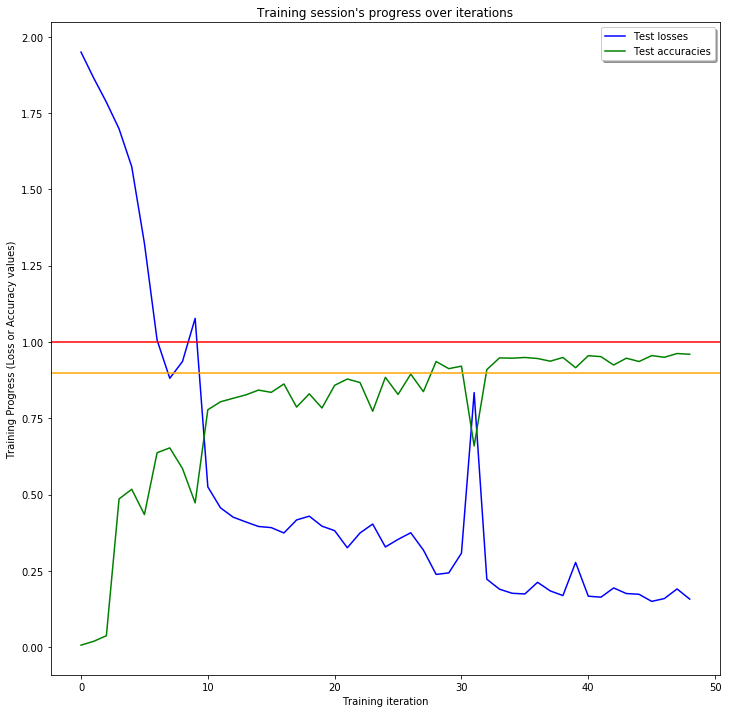

Training iter #1470000:   Batch Loss = 0.025852, Accuracy = 0.9950000047683716
PERFORMANCE ON TEST SET: Batch Loss = 0.15760065615177155, Accuracy = 0.9599591493606567
Optimization Finished!
FINAL RESULT: Batch Loss = 0.15760065615177155, Accuracy = 0.9599591493606567


In [15]:
start_learning_time = time()

from IPython.display import clear_output
#To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

def learn_easier(bx, by):
    _, loss, acc = sess.run(
        [optimizer_easier, cost_easier, accuracy_easier],
        feed_dict={
            x: bx, 
            y: by
        }
    )
    return loss, acc

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
diter = 0
while step * batch_size <= training_iters:
    batch_xs, batch_ys = extract_batch_xy(X_train, y_easier_train, step, batch_size)

    # Fit training using batch data
    loss, acc = learn_easier(batch_xs, batch_ys)
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if is_notebook() and step * batch_size % display_iter == 0:
        diter += 1
        # To not spam console, show training accuracy/loss in this "if"
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss2, acc2 = sess.run(
            [cost_easier, accuracy_easier], 
            feed_dict={
                x: X_test,
                y: one_hot(y_easier_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)
        clear_output(True)

        width = 12
        height = 12
        plt.figure(figsize=(width, height))
        
        ixs = np.array(range(diter))
        plt.plot(ixs, np.array(test_losses),     "b-", label="Test losses")
        plt.plot(ixs, np.array(test_accuracies), "g-", label="Test accuracies")

        plt.axhline(y=1.0, c='r')
        plt.axhline(y=0.9, c='orange')

        plt.title("Training session's progress over iterations")
        plt.legend(loc='upper right', shadow=True)
        plt.ylabel('Training Progress (Loss or Accuracy values)')
        plt.xlabel('Training iteration')

        plt.show()
        
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss2) + \
              ", Accuracy = {}".format(acc2))
        
    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracyv, final_loss = sess.run(
    [pred_easier, accuracy_easier, cost_easier],
    feed_dict={
        x: X_test,
        y: one_hot(y_easier_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracyv)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracyv))


### Second stage (normal)

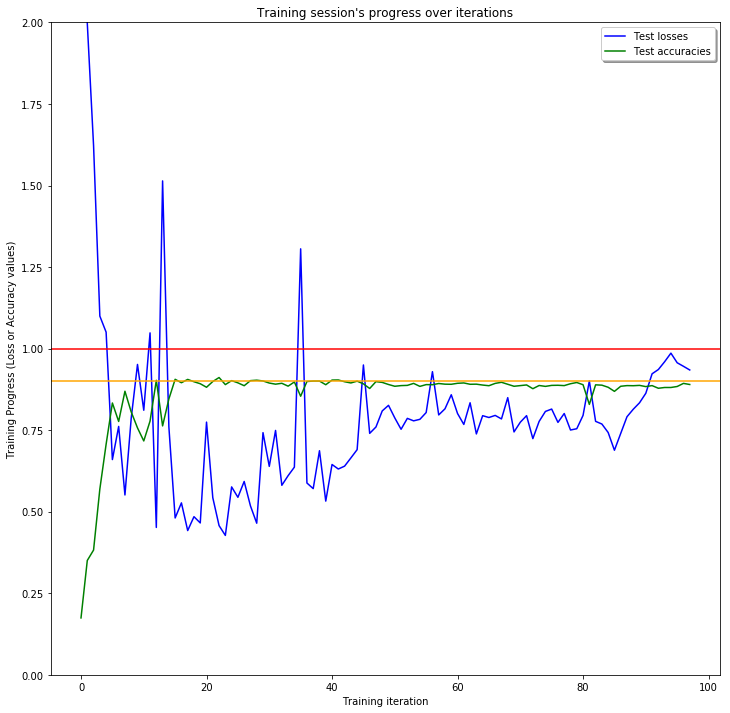

Training iter #2940000:   Batch Loss = 0.094286, Accuracy = 0.9515000581741333
PERFORMANCE ON TEST SET: Batch Loss = 0.9345753788948059, Accuracy = 0.8900576233863831
Optimization Finished!
FINAL RESULT: Batch Loss = 0.9345753788948059, Accuracy = 0.8900575637817383


In [16]:
from IPython.display import clear_output
#To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
diter = 0
training_iters2 = training_iters * 2
while step * batch_size <= training_iters2:
    batch_xs, batch_ys = extract_batch_xy(X_train, y_train, step, batch_size)
    
    if step * batch_size <= training_iters2 / 2:
        learn_easier(batch_xs, batch_ys)
    
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if is_notebook() and step * batch_size % display_iter == 0:
        diter += 1
        # To not spam console, show training accuracy/loss in this "if"
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)
        clear_output(True)

        width = 12
        height = 12
        plt.figure(figsize=(width, height))
        
        ixs = np.array(range(diter))
        plt.plot(ixs, np.array(test_losses),     "b-", label="Test losses")
        plt.plot(ixs, np.array(test_accuracies), "g-", label="Test accuracies")

        plt.axhline(y=1.0, c='r')
        plt.axhline(y=0.9, c='orange')

        plt.title("Training session's progress over iterations")
        plt.legend(loc='upper right', shadow=True)
        plt.ylabel('Training Progress (Loss or Accuracy values)')
        plt.xlabel('Training iteration')
        plt.ylim(0, 2)
        plt.show()
        
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss2) + \
              ", Accuracy = {}".format(acc2))
        
    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracyv, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracyv)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracyv))


In [17]:
if not is_notebook():
    one_hot_predictions, accuracyv, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    argsdict = dict(args.__dict__)
    argsdict.update({
        "accuracy": float(accuracyv),
        "time": float(time() - start_learning_time),
        "memory": sum(int(np.prod(var.shape)) for var in tf.trainable_variables()) * 4,
    })
    print("RESULT " + str(argsdict))
    exit(0)

### A вот так выглядят данные. Экспоненциально сглажены для лучшего восприятия

'WALKING'

LSTM-2steps-gru=1-select_parameters.ipynb:5: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,adjust=True,min_periods=0,halflife=5).mean()
  "metadata": {},
LSTM-2steps-gru=1-select_parameters.ipynb:7: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,adjust=True,min_periods=0,halflife=7).mean()
  "# GRU for Human Activity Recognition\n",


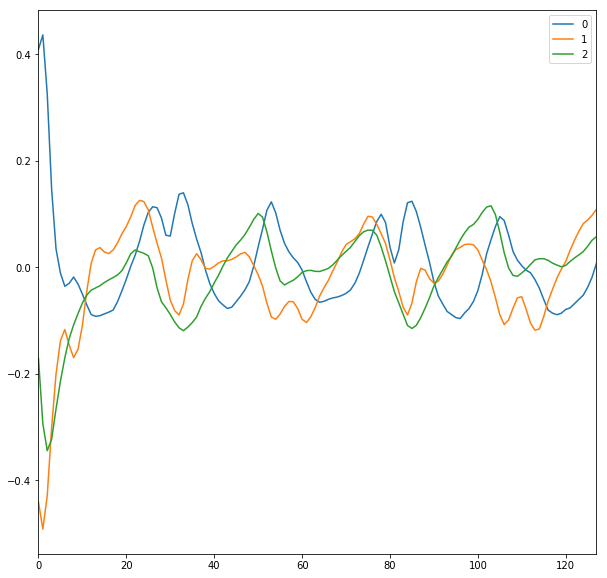

'STANDING'

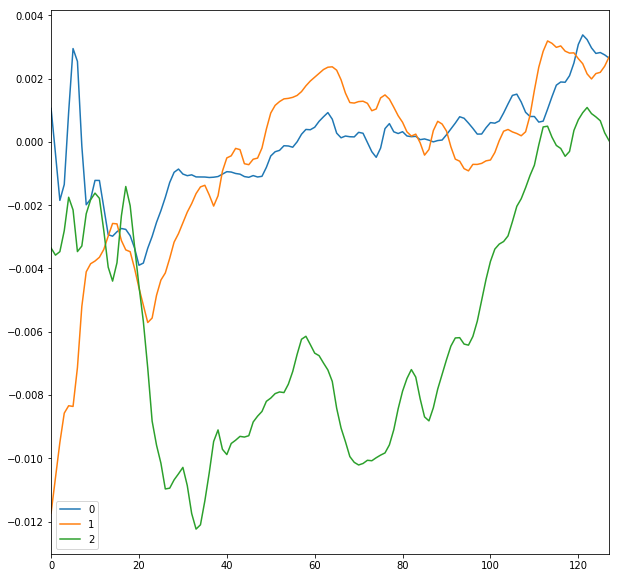

In [20]:
if is_notebook():
    import pandas as pd
    def show_serie(i):
        display(LABELS[int(y_train[i])])
        sm = pd.ewma(pd.DataFrame(X_train[i]), halflife=5)

        pd.ewma(pd.DataFrame(X_train[i]), halflife=7).iloc[:, 0:3].plot(figsize=(10, 10))
        plt.show()

    show_serie(0)
    show_serie(101)

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

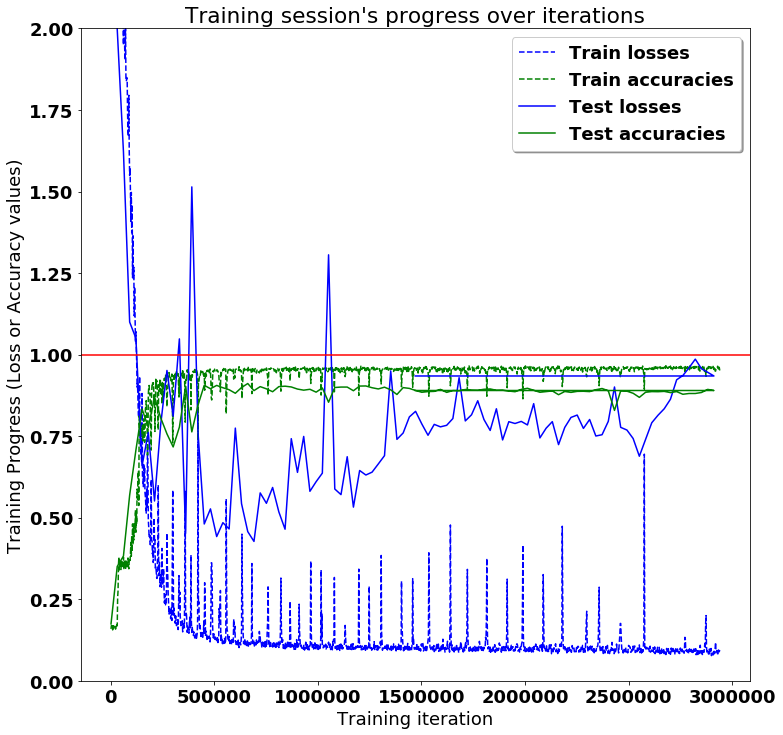

In [21]:
# (Inline plots: )
%matplotlib inline

font = {
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.axhline(y=1.0, c='r')

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.ylim(0, 2)
plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: Tensor("mul:0", shape=(), dtype=float32)%

Precision: 89.3297964733004%
Recall: 89.00576857821514%
f1_score: 88.97248375404025%

Confusion Matrix:
[[456  17  22   0   1   0]
 [ 39 420  12   0   0   0]
 [  2   6 410   0   2   0]
 [  2  22   0 427  39   1]
 [ 14   0   0 117 400   1]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[ 15.47336292   0.57685781   0.74652189   0.           0.03393281   0.        ]
 [  1.32337964  14.25178242   0.40719375   0.           0.           0.        ]
 [  0.06786563   0.20359688  13.9124527    0.           0.06786563   0.        ]
 [  0.06786563   0.74652189   0.          14.48931122   1.32337964
    0.03393281]
 [  0.47505939   0.           0.           3.97013903  13.57312489
    0.03393281]
 [  0.           0.91618598   0.           0.           0.          17.30573463]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data

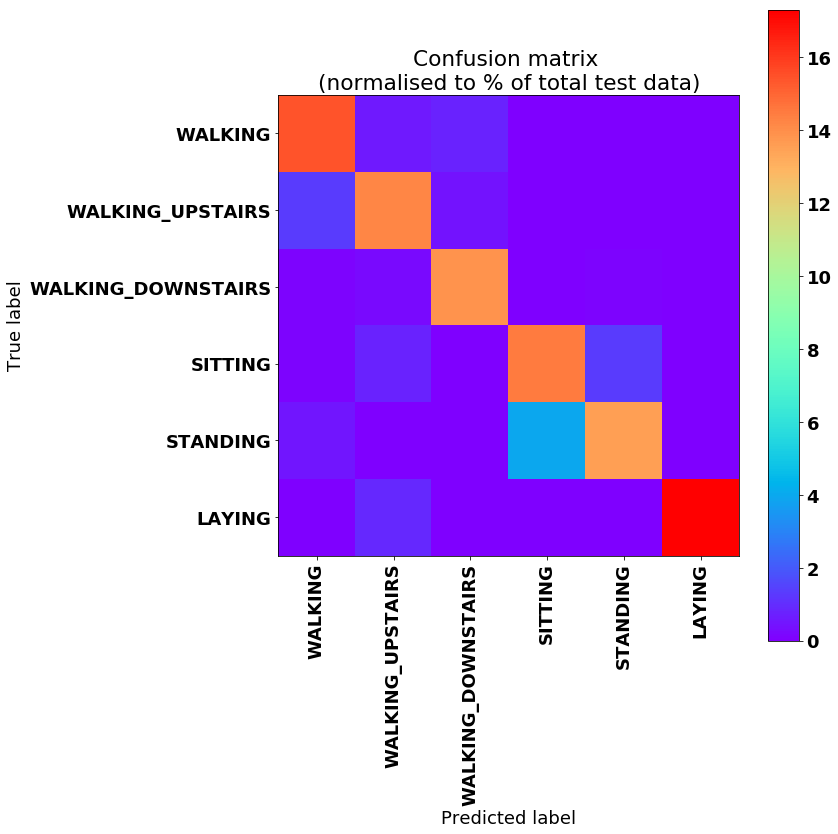

In [22]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
sess.close()

## Conclusion

Outstandingly, **the final accuracy is of about 90%** (depends of launch)!

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so those predictions are extremely accurate.

I specially did not expect such good results for guessing between "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away from the identity. This is great.

It is also possible to see that there was a slight difficulty in doing the difference between "WALKING", "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS". Obviously, those activities are quite similar in terms of movements. 

In [24]:
os.system("jupyter nbconvert --to markdown " + nb_name)
os.system("jupyter nbconvert --to python " + nb_name)
nb_name

'LSTM-2steps-gru=1-select_parameters.ipynb'

In [26]:
pyname = nb_name[:-6] + ".py"
pyname

'LSTM-2steps-gru=1-select_parameters.py'

## Parameters selection

In [52]:
import pandas as pd
def dict_protocol_to_dataframe(protocol):
    return pd.read_json('[' + protocol.replace("'", '"').replace('\n', ',') + ']')

dict_protocol_to_dataframe("""\
{'time': 548.2270517349243, 'n_hidden': 1, 'lr': 0.0025, 'accuracy': 0.6878181099891663, 'memory': 532, 'batch_size': 2000, 'training_iterate_dataset_times': 200}
{'lr': 0.0025, 'training_iterate_dataset_times': 200, 'n_hidden': 2, 'batch_size': 2000, 'accuracy': 0.7770613431930542, 'memory': 728, 'time': 566.6135125160217}\
""")

,accuracy,batch_size,lr,memory,n_hidden,time,training_iterate_dataset_times
0,0.687818,2000,0.0025,532,1,548.227052,200
1,0.777061,2000,0.0025,728,2,566.613513,200


In [38]:
#bench hhidden
bench_cmd = """
for i in {1..25}; do \
    python3 %s \
    --nhidden $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % pyname
get_ipython().system("bash -c '" + bench_cmd + "'")

{'time': 548.2270517349243, 'n_hidden': 1, 'lr': 0.0025, 'accuracy': 0.6878181099891663, 'memory': 532, 'batch_size': 2000, 'training_iterate_dataset_times': 200}
{'lr': 0.0025, 'training_iterate_dataset_times': 200, 'n_hidden': 2, 'batch_size': 2000, 'accuracy': 0.7770613431930542, 'memory': 728, 'time': 566.6135125160217}
{'n_hidden': 3, 'accuracy': 0.7634882926940918, 'training_iterate_dataset_times': 200, 'time': 511.60548186302185, 'memory': 972, 'batch_size': 2000, 'lr': 0.0025}
{'n_hidden': 4, 'lr': 0.0025, 'time': 516.9239003658295, 'training_iterate_dataset_times': 200, 'batch_size': 2000, 'accuracy': 0.8676619529724121, 'memory': 1264}
{'lr': 0.0025, 'batch_size': 2000, 'accuracy': 0.8388190865516663, 'memory': 1604, 'training_iterate_dataset_times': 200, 'time': 531.829683303833, 'n_hidden': 5}
{'accuracy': 0.828299880027771, 'lr': 0.0025, 'time': 548.8622722625732, 'memory': 1992, 'n_hidden': 6, 'training_iterate_dataset_times': 200, 'batch_size': 2000}
{'memory': 2428, 'ti

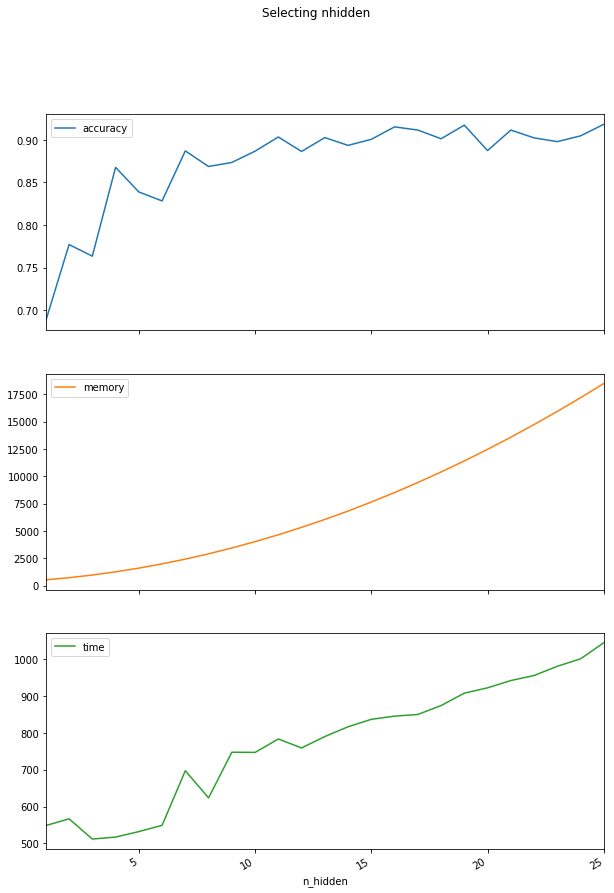

In [73]:
bench_nhidden_protocol = """\
{'time': 548.2270517349243, 'n_hidden': 1, 'lr': 0.0025, 'accuracy': 0.6878181099891663, 'memory': 532, 'batch_size': 2000, 'training_iterate_dataset_times': 200}
{'lr': 0.0025, 'training_iterate_dataset_times': 200, 'n_hidden': 2, 'batch_size': 2000, 'accuracy': 0.7770613431930542, 'memory': 728, 'time': 566.6135125160217}
{'n_hidden': 3, 'accuracy': 0.7634882926940918, 'training_iterate_dataset_times': 200, 'time': 511.60548186302185, 'memory': 972, 'batch_size': 2000, 'lr': 0.0025}
{'n_hidden': 4, 'lr': 0.0025, 'time': 516.9239003658295, 'training_iterate_dataset_times': 200, 'batch_size': 2000, 'accuracy': 0.8676619529724121, 'memory': 1264}
{'lr': 0.0025, 'batch_size': 2000, 'accuracy': 0.8388190865516663, 'memory': 1604, 'training_iterate_dataset_times': 200, 'time': 531.829683303833, 'n_hidden': 5}
{'accuracy': 0.828299880027771, 'lr': 0.0025, 'time': 548.8622722625732, 'memory': 1992, 'n_hidden': 6, 'training_iterate_dataset_times': 200, 'batch_size': 2000}
{'memory': 2428, 'time': 697.2729513645172, 'training_iterate_dataset_times': 200, 'accuracy': 0.8870037198066711, 'lr': 0.0025, 'n_hidden': 7, 'batch_size': 2000}
{'n_hidden': 8, 'memory': 2912, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'accuracy': 0.8686800003051758, 'time': 623.4119627475739}
{'accuracy': 0.8734305500984192, 'training_iterate_dataset_times': 200, 'batch_size': 2000, 'time': 747.621160030365, 'n_hidden': 9, 'lr': 0.0025, 'memory': 3444}
{'lr': 0.0025, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'n_hidden': 10, 'accuracy': 0.8866643905639648, 'memory': 4024, 'time': 747.1461205482483}
{'memory': 4652, 'time': 783.5858447551727, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'batch_size': 2000, 'n_hidden': 11, 'accuracy': 0.9032914042472839}
{'accuracy': 0.8863250017166138, 'n_hidden': 12, 'time': 759.2517018318176, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'memory': 5328}
{'memory': 6052, 'accuracy': 0.9026128053665161, 'training_iterate_dataset_times': 200, 'batch_size': 2000, 'n_hidden': 13, 'time': 790.246125459671, 'lr': 0.0025}
{'training_iterate_dataset_times': 200, 'batch_size': 2000, 'accuracy': 0.8934509754180908, 'memory': 6824, 'n_hidden': 14, 'time': 816.7725872993469, 'lr': 0.0025}
{'lr': 0.0025, 'memory': 7644, 'n_hidden': 15, 'time': 837.0443296432495, 'accuracy': 0.9005767703056335, 'batch_size': 2000, 'training_iterate_dataset_times': 200}
{'training_iterate_dataset_times': 200, 'lr': 0.0025, 'accuracy': 0.9151678681373596, 'time': 845.7109208106995, 'batch_size': 2000, 'n_hidden': 16, 'memory': 8512}
{'training_iterate_dataset_times': 200, 'accuracy': 0.9114352464675903, 'batch_size': 2000, 'memory': 9428, 'time': 850.2257452011108, 'lr': 0.0025, 'n_hidden': 17}
{'batch_size': 2000, 'memory': 10392, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'time': 874.3771314620972, 'accuracy': 0.9012555480003357, 'n_hidden': 18}
{'time': 908.1808974742889, 'accuracy': 0.9172038435935974, 'memory': 11404, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'batch_size': 2000, 'n_hidden': 19}
{'batch_size': 2000, 'memory': 12464, 'time': 922.6409084796906, 'lr': 0.0025, 'accuracy': 0.8873429894447327, 'n_hidden': 20, 'training_iterate_dataset_times': 200}
{'memory': 13572, 'accuracy': 0.9114352464675903, 'training_iterate_dataset_times': 200, 'time': 942.4592912197113, 'lr': 0.0025, 'n_hidden': 21, 'batch_size': 2000}
{'training_iterate_dataset_times': 200, 'n_hidden': 22, 'memory': 14728, 'lr': 0.0025, 'batch_size': 2000, 'time': 956.1021647453308, 'accuracy': 0.9022734761238098}
{'training_iterate_dataset_times': 200, 'accuracy': 0.8978621959686279, 'batch_size': 2000, 'time': 981.2456750869751, 'lr': 0.0025, 'memory': 15932, 'n_hidden': 23}
{'memory': 17184, 'time': 1001.4945929050446, 'accuracy': 0.9046486616134644, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'n_hidden': 24, 'batch_size': 2000}
{'batch_size': 2000, 'training_iterate_dataset_times': 200, 'accuracy': 0.9182217121124268, 'n_hidden': 25, 'lr': 0.0025, 'memory': 18484, 'time': 1045.393786430359}"""

data = dict_protocol_to_dataframe(bench_nhidden_protocol)
data = data.set_index('n_hidden')

data[["accuracy", "memory", "time"]].plot(subplots=True, figsize=(10,15), title="Selecting nhidden")
plt.show()

In [46]:
#bench lr
bench_cmd = """
for i in %s; do \
    python3 %s \
    --lr $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % (" ".join(map(str, np.arange(0.0005, 0.005, 0.0002))), pyname)
get_ipython().system("bash -c '" + bench_cmd + "'")

{'n_hidden': 16, 'memory': 8512, 'time': 918.8063745498657, 'batch_size': 2000, 'accuracy': 0.8839496970176697, 'training_iterate_dataset_times': 200, 'lr': 0.0005}
{'lr': 0.0007, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'memory': 8512, 'n_hidden': 16, 'time': 945.0494077205658, 'accuracy': 0.8537495136260986}
{'time': 919.407149553299, 'accuracy': 0.9070240259170532, 'memory': 8512, 'batch_size': 2000, 'lr': 0.0009, 'n_hidden': 16, 'training_iterate_dataset_times': 200}
{'accuracy': 0.903630793094635, 'time': 916.8244714736938, 'n_hidden': 16, 'lr': 0.0011, 'batch_size': 2000, 'memory': 8512, 'training_iterate_dataset_times': 200}
{'n_hidden': 16, 'accuracy': 0.8887002468109131, 'lr': 0.0013, 'training_iterate_dataset_times': 200, 'memory': 8512, 'batch_size': 2000, 'time': 848.604528427124}
{'n_hidden': 16, 'memory': 8512, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'time': 846.0046770572662, 'accuracy': 0.88802170753479, 'lr': 0.0015}
{'accuracy': 0.

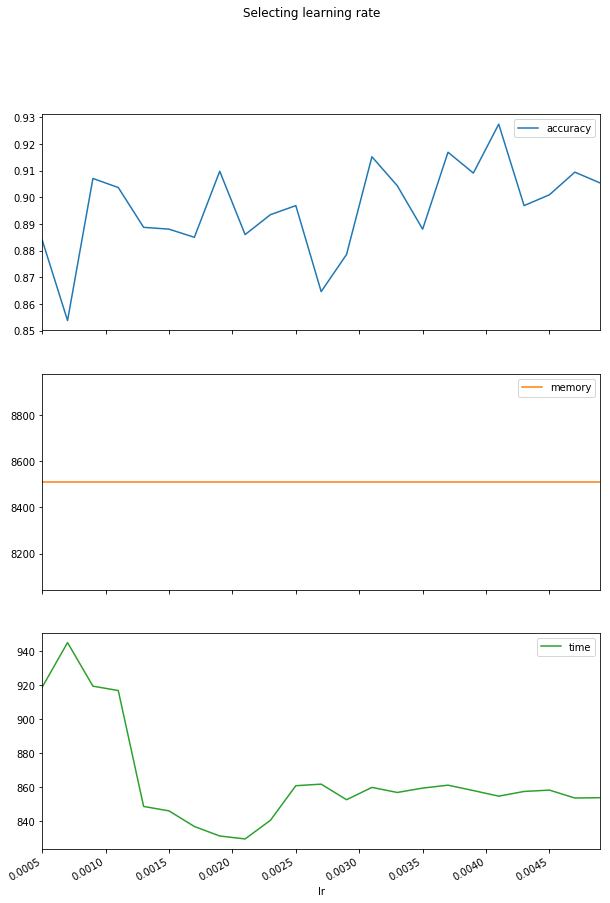

In [74]:
bench_nhidden_protocol = """\
{'n_hidden': 16, 'memory': 8512, 'time': 918.8063745498657, 'batch_size': 2000, 'accuracy': 0.8839496970176697, 'training_iterate_dataset_times': 200, 'lr': 0.0005}
{'lr': 0.0007, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'memory': 8512, 'n_hidden': 16, 'time': 945.0494077205658, 'accuracy': 0.8537495136260986}
{'time': 919.407149553299, 'accuracy': 0.9070240259170532, 'memory': 8512, 'batch_size': 2000, 'lr': 0.0009, 'n_hidden': 16, 'training_iterate_dataset_times': 200}
{'accuracy': 0.903630793094635, 'time': 916.8244714736938, 'n_hidden': 16, 'lr': 0.0011, 'batch_size': 2000, 'memory': 8512, 'training_iterate_dataset_times': 200}
{'n_hidden': 16, 'accuracy': 0.8887002468109131, 'lr': 0.0013, 'training_iterate_dataset_times': 200, 'memory': 8512, 'batch_size': 2000, 'time': 848.604528427124}
{'n_hidden': 16, 'memory': 8512, 'batch_size': 2000, 'training_iterate_dataset_times': 200, 'time': 846.0046770572662, 'accuracy': 0.88802170753479, 'lr': 0.0015}
{'accuracy': 0.8849677443504333, 'memory': 8512, 'time': 836.8066127300262, 'lr': 0.0017, 'n_hidden': 16, 'batch_size': 2000, 'training_iterate_dataset_times': 200}
{'batch_size': 2000, 'memory': 8512, 'n_hidden': 16, 'accuracy': 0.9097387194633484, 'time': 831.2143180370331, 'lr': 0.0019, 'training_iterate_dataset_times': 200}
{'accuracy': 0.8859856128692627, 'time': 829.4784965515137, 'n_hidden': 16, 'lr': 0.0021, 'training_iterate_dataset_times': 200, 'batch_size': 2000, 'memory': 8512}
{'batch_size': 2000, 'training_iterate_dataset_times': 200, 'n_hidden': 16, 'accuracy': 0.8934508562088013, 'lr': 0.0023, 'memory': 8512, 'time': 840.4800877571106}
{'memory': 8512, 'n_hidden': 16, 'time': 860.8175151348114, 'training_iterate_dataset_times': 200, 'batch_size': 2000, 'lr': 0.0025, 'accuracy': 0.896844208240509}
{'lr': 0.0027, 'memory': 8512, 'time': 861.7281455993652, 'accuracy': 0.8646079897880554, 'training_iterate_dataset_times': 200, 'n_hidden': 16, 'batch_size': 2000}
{'accuracy': 0.8785204887390137, 'batch_size': 2000, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'memory': 8512, 'time': 852.5642709732056, 'lr': 0.0029}
{'batch_size': 2000, 'training_iterate_dataset_times': 200, 'time': 859.8158564567566, 'lr': 0.0031, 'memory': 8512, 'accuracy': 0.9151679277420044, 'n_hidden': 16}
{'lr': 0.0033, 'batch_size': 2000, 'accuracy': 0.9043093323707581, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'memory': 8512, 'time': 856.8357677459717}
{'batch_size': 2000, 'training_iterate_dataset_times': 200, 'memory': 8512, 'time': 859.4028468132019, 'lr': 0.0035, 'n_hidden': 16, 'accuracy': 0.88802170753479}
{'accuracy': 0.9168644547462463, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'memory': 8512, 'time': 861.1274554729462, 'lr': 0.0037, 'batch_size': 2000}
{'batch_size': 2000, 'lr': 0.0039, 'time': 857.9518365859985, 'n_hidden': 16, 'memory': 8512, 'accuracy': 0.909060001373291, 'training_iterate_dataset_times': 200}
{'lr': 0.0041, 'time': 854.6585085391998, 'training_iterate_dataset_times': 200, 'n_hidden': 16, 'accuracy': 0.9273837208747864, 'batch_size': 2000, 'memory': 8512}
{'n_hidden': 16, 'lr': 0.0043, 'accuracy': 0.896844208240509, 'memory': 8512, 'training_iterate_dataset_times': 200, 'time': 857.4266705513, 'batch_size': 2000}
{'training_iterate_dataset_times': 200, 'time': 858.2252700328827, 'memory': 8512, 'batch_size': 2000, 'lr': 0.0045, 'n_hidden': 16, 'accuracy': 0.9009160399436951}
{'batch_size': 2000, 'accuracy': 0.9093992710113525, 'memory': 8512, 'n_hidden': 16, 'lr': 0.0047, 'training_iterate_dataset_times': 200, 'time': 853.5595598220825}
{'time': 853.7582416534424, 'training_iterate_dataset_times': 200, 'accuracy': 0.9053274393081665, 'n_hidden': 16, 'batch_size': 2000, 'lr': 0.0049, 'memory': 8512}"""

data = dict_protocol_to_dataframe(bench_nhidden_protocol)
data = data.set_index('lr')

data[["accuracy", "memory", "time"]].plot(subplots=True, figsize=(10,15), title="Selecting learning rate")
plt.show()

In [29]:
#bench batch size
bench_cmd = """
for i in %s; do \
    python3 %s \
    --bsize $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % (" ".join(map(str, range(200, 4000, 200))), pyname)
print(bench_cmd)
get_ipython().system("bash -c '" + bench_cmd + "'")


for i in 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3600 3800; do     python3 LSTM-2steps-gru=1-select_parameters.py     --bsize $i --training_iterate_dataset_times 200    2> full_bench.err     | tee -a full_bench.log     | grep -e "^RESULT" | cut -c 8-     | tee -a bench.log; done

^C
